In [1]:
using Kinbiont
using DifferentialEquations
using CSV
using SymbolicRegression
using Plots
using StatsBase
using Distributions
using OptimizationBBO
using Optimization
using NaNMath

In this example, we simulate a system of ODEs with Kinbiont.
One of the parameters in the system (param[4]) is affected by an experimental feature.
The dependence of this parameter on the feature is **quadratic**: param[4] = param0 * (1 - feature)^2.
The goal is to fit the ODE system to data generated under different feature values
and then apply symbolic regression to recover the underlying relationship.

In [2]:
# Function defining the unknown quadratic response of the parameter to the feature
function unknown_response(feature)
    response = (1 - feature)^2
    return response
end

unknown_response (generic function with 1 method)

In [3]:
# Function defining time-dependent activity, used in the ODE system
function time_dep(time)
    activity = exp((- (time - 20)^2) / 20)
    return activity
end

time_dep (generic function with 1 method)

In [4]:
# Defining the system of ODEs a tres state system. Where, the first state are bacteria reproduciing eating the nutrient (u[4), the production of the second state has a time dependent activity and the third state is produced by the second state with a constant maturation rate.
function model_1(du, u, param, t)
    # u[1]: Population 1
    # u[2]: Intermediate state 1
    # u[3]: Intermediate state 2
    # u[4]: Available resource
    
    du[1] = param[1] * u[1] * u[4]  # Growth equation
    du[2] = time_dep(t) * param[4] * u[1] - param[3] * u[2] - param[2] * u[2]  # Intermediate process
    du[3] = param[3] * u[2] - param[2] * u[3]  # Second intermediate process
    du[4] = -du[1]  # Resource depletion
end

model_1 (generic function with 1 method)

In [5]:
# Initial conditions for the variables
u0 = [0.1, 0.0, 0.0, 1.0]

4-element Vector{Float64}:
 0.1
 0.0
 0.0
 1.0

In [6]:
# Parameters: [growth rate, degradation rate, conversion rate, feature-dependent parameter]
param = [0.1, 0.001, 0.5, 0.42]
lb1 = [0.01, 0.0001, 0.1, 0.0]
ub1 = [0.2, 0.3, 1.1, 1.0]
param_guess = lb1 .+ (ub1 .- lb1) ./ 2

4-element Vector{Float64}:
 0.105
 0.15005
 0.6
 0.5

In [7]:
param0 = param[4]  # Store initial value of the feature-dependent parameter
noise_value = 0.01  # Noise level

0.01

In [8]:
# Defining the range of the perturbation on the feature
results_fit = Any
feature_range = 0.0:0.1:2.0

0.0:0.1:2.0

Experiment with feature as 0.0

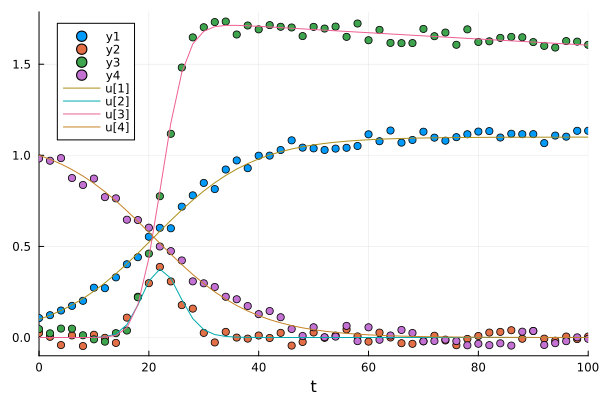

Experiment with feature as 0.1

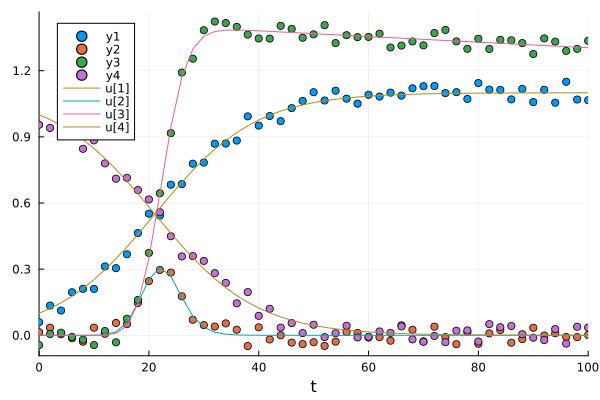

Experiment with feature as 0.2

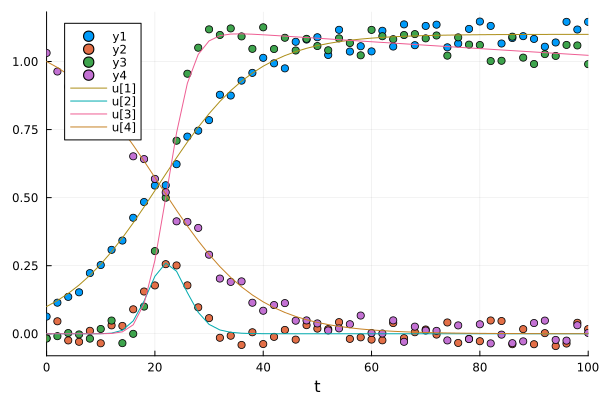

Experiment with feature as 0.3

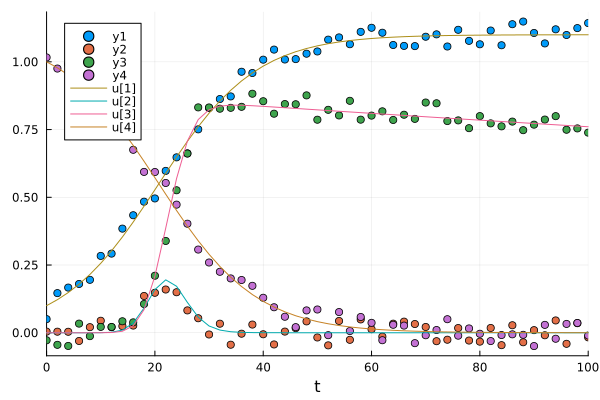

Experiment with feature as 0.4

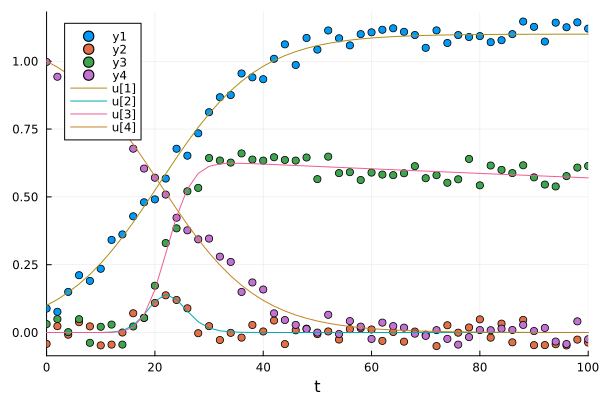

Experiment with feature as 0.5

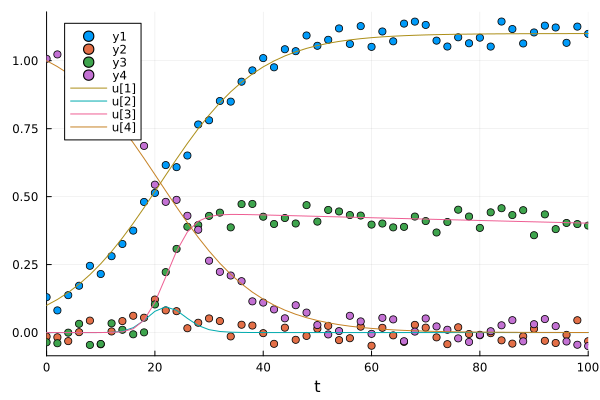

Experiment with feature as 0.6

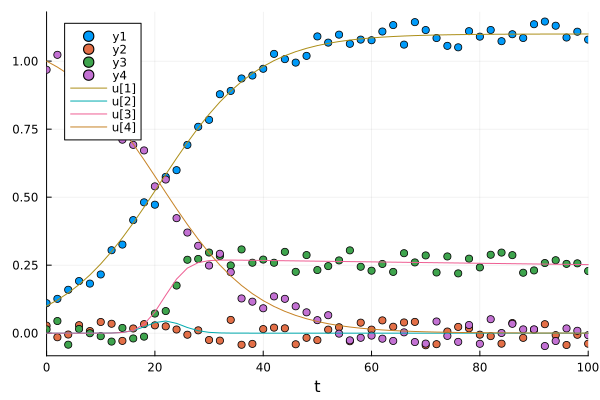

Experiment with feature as 0.7

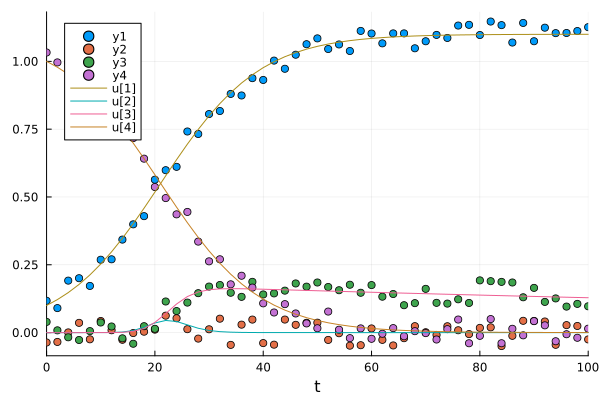

Experiment with feature as 0.8

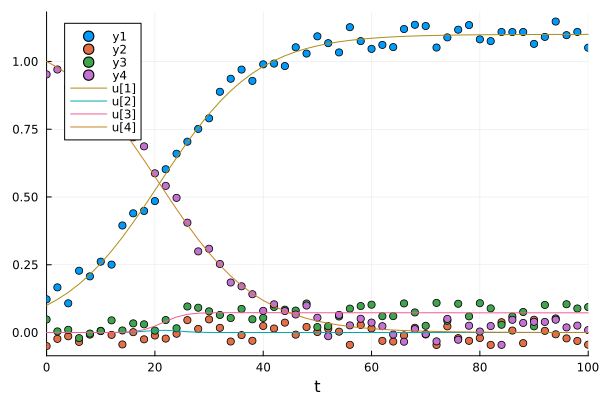

Experiment with feature as 0.9

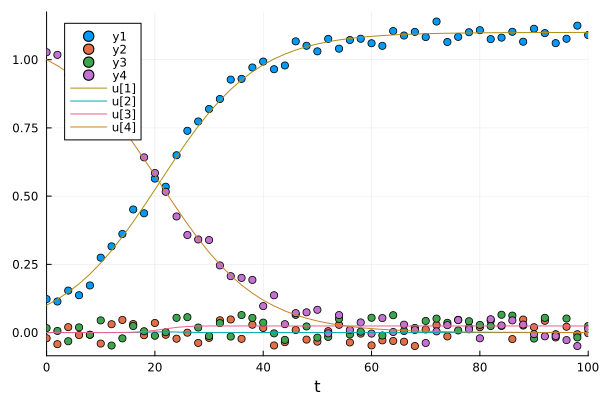

Experiment with feature as 1.0

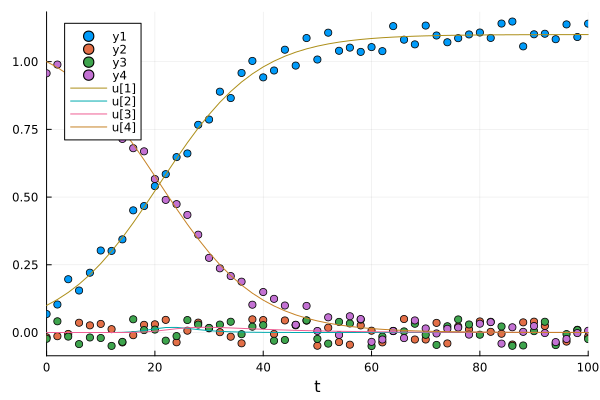

Experiment with feature as 1.1

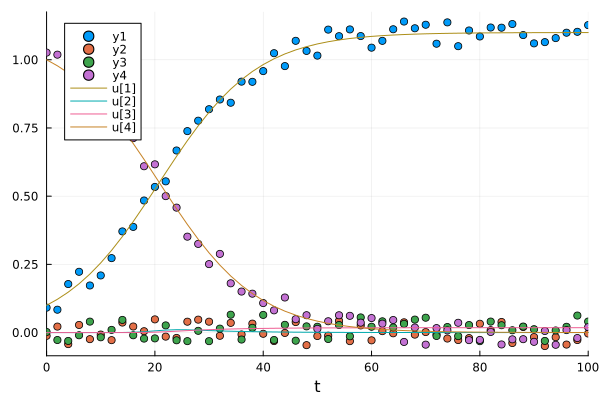

Experiment with feature as 1.2

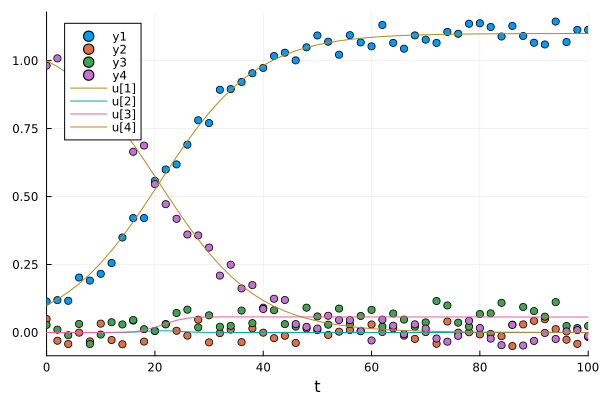

Experiment with feature as 1.3

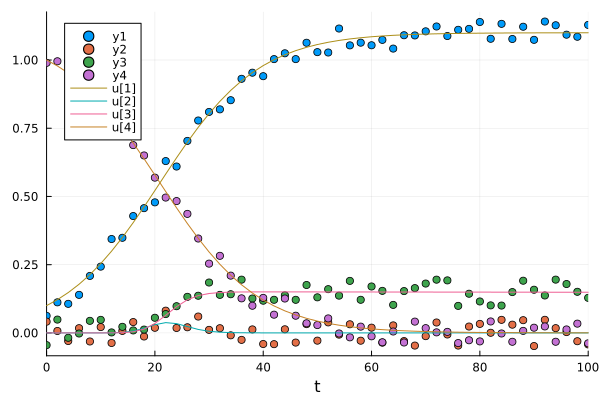

Experiment with feature as 1.4

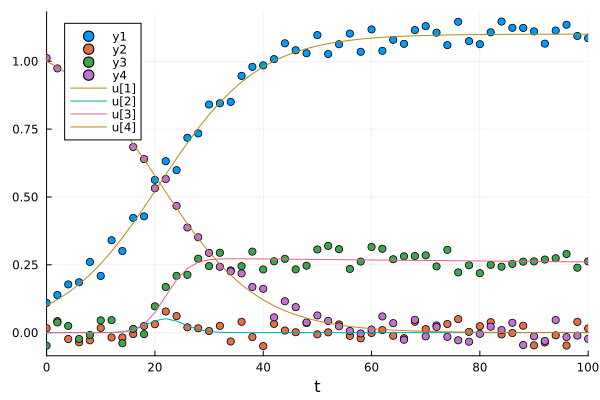

Experiment with feature as 1.5

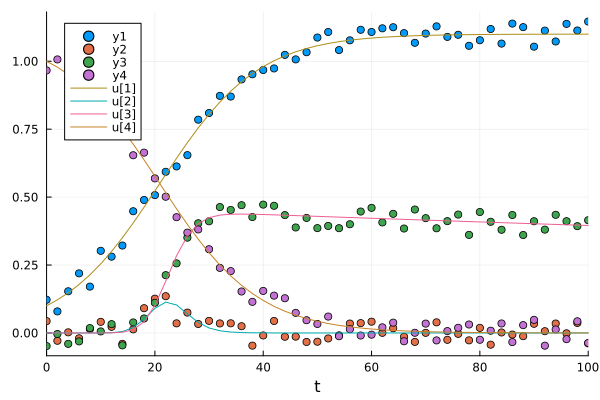

Experiment with feature as 1.6

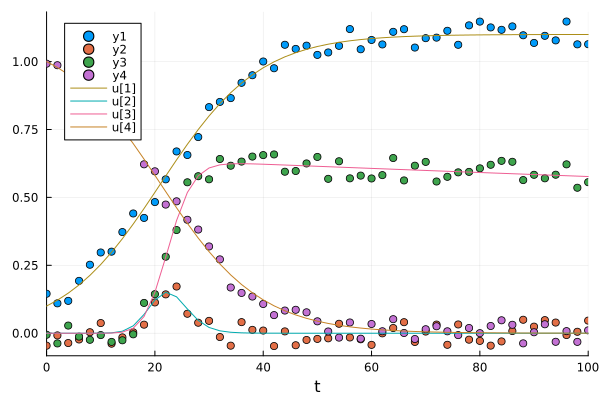

Experiment with feature as 1.7

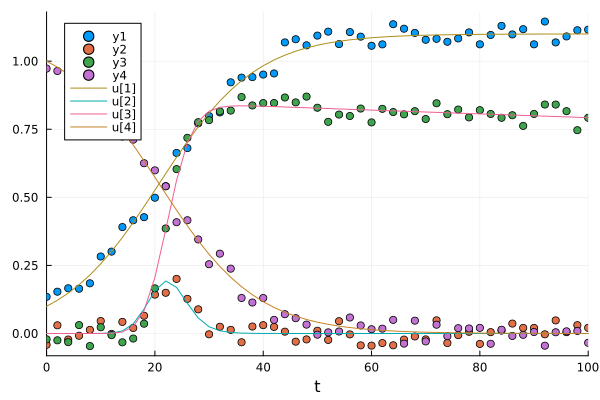

Experiment with feature as 1.8

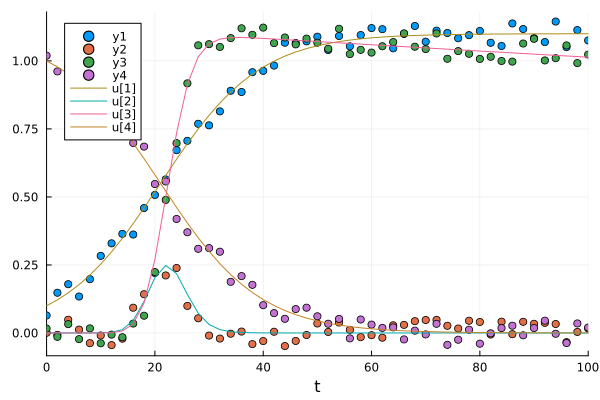

Experiment with feature as 1.9

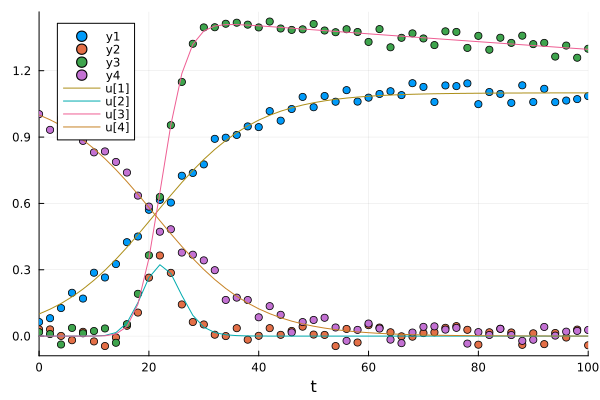

Experiment with feature as 2.0

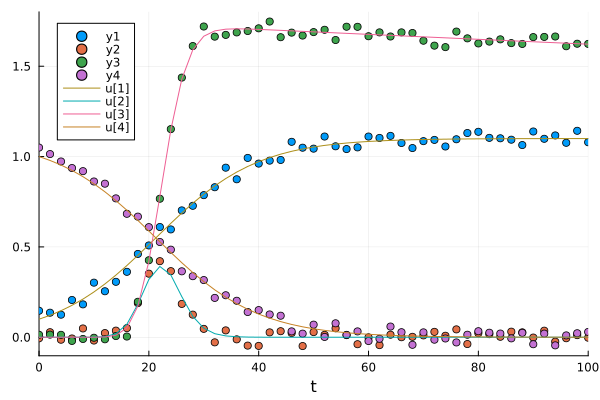

In [19]:
for f in feature_range
    plot(0, 0)  # Empty plot for visualization
    # Quadratic dependence of param[4] on the feature
    param[4] = param0 * unknown_response(f)

    # Calling the simulation function
    Simulation = ODEs_system_sim(
        model_1,  # Model function
        u0,       # Initial conditions
        0.0,      # Start time
        100.0,    # End time
        2.0,      # Time step
        param     # Model parameters
    )

    # Extracting simulation results
    sol_time = reduce(hcat, Simulation.t)
    sol_t = reduce(hcat, Simulation.u)

    # Adding uniform random noise to simulation data
    sol_t_noise = [sol_t[i, :] .+ rand(Uniform(-0.05, 0.05), size(sol_t)[2]) for i in 1:size(sol_t)[1]]
    sol_t_noise = permutedims(reduce(hcat, sol_t_noise))
    
    data = vcat(sol_time, sol_t_noise)  # Final dataset
    display("text/html", "<h2>Experiment with feature as $f</h2>") 

    # Plot data with noise for different system variables
    scatter(data[1, :], data[2, :])
    scatter!(data[1, :], data[3, :])
    scatter!(data[1, :], data[4, :])
    scatter!(data[1, :], data[5, :])

    # Fit ODE system to noisy data
    fit = fit_ODEs_System(
        data,
        string(f),
        model_1, 
        param_guess,
        u0;
        lb=lb1,
        ub=ub1
    )

    display(plot!(fit[3]))  # Plot fitted model results

    # Storing fitted results for symbolic regression
    if f == feature_range[1]
        results_fit = fit[2]
    else
        results_fit = vcat(results_fit, reduce(hcat, fit[2][2, :]))
    end
end

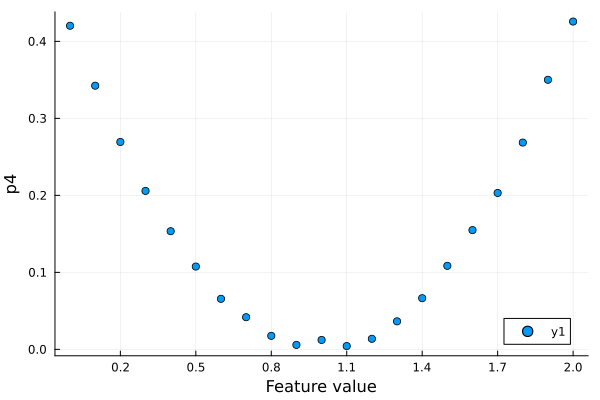

In [20]:
# Scatter plot of feature value vs. estimated parameter p4
scatter(results_fit[2:end, 1], results_fit[2:end, 6], xlabel="Feature value", ylabel="p4")

In [21]:
# Setting options for symbolic regression
options = SymbolicRegression.Options(
    binary_operators=[+, /, *, -],
    unary_operators=[square],
    constraints=nothing,
    elementwise_loss=nothing,
    loss_function=nothing,
    tournament_selection_n=12,
    tournament_selection_p=0.86,
    topn=12,
    complexity_of_operators=nothing,
    complexity_of_constants=nothing,
    complexity_of_variables=nothing,
    parsimony=0.05,
    dimensional_constraint_penalty=nothing,
    alpha=0.100000,
    maxsize=10,
    maxdepth=nothing
)

Options(binops=Function[+, /, *, -], unaops=Function[SymbolicRegression.CoreModule.OperatorsModule.square], bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=[-1], complexity_mapping=SymbolicRegression.CoreModule.OptionsStructModule.ComplexityMapping{Int64}(false, Int64[], Int64[], 1, 1), tournament_selection_n=12, tournament_selection_p=0.86, tournament_selection_weights=[0.86, 0.12040000000000001, 0.016856000000000003, 0.0023598400000000006, 0.0003303776000000001, 4.625286400000002e-5, 6.475400960000003e-6, 9.065561344000006e-7, 1.2691785881600008e-7, 1.7768500234240014e-8, 2.4875900327936024e-9, 3.482626045911044e-10], parsimony=0.05, dimensional_constraint_penalty=nothing, alpha=0.1, maxsize=10, maxdepth=10, turbo=false, migration=true, hof_migration=true, should_simplify=true, should_optimize_constants=true, output_file=hall_of_fame_2025-03-24_200351.580.csv, populations=15, perturbation_factor=0.076, annealing=false, batching=false, batch_size=50, mutation

In [22]:
# Generating feature matrix for symbolic regression
feature_matrix = [[string(f), f] for f in feature_range]
feature_matrix = permutedims(reduce(hcat, feature_matrix))

21×2 Matrix{Any}:
 "0.0"  0.0
 "0.1"  0.1
 "0.2"  0.2
 "0.3"  0.3
 "0.4"  0.4
 "0.5"  0.5
 "0.6"  0.6
 "0.7"  0.7
 "0.8"  0.8
 "0.9"  0.9
 "1.0"  1.0
 "1.1"  1.1
 "1.2"  1.2
 "1.3"  1.3
 "1.4"  1.4
 "1.5"  1.5
 "1.6"  1.6
 "1.7"  1.7
 "1.8"  1.8
 "1.9"  1.9
 "2.0"  2.0

In [23]:
results_fit[:, 2] = results_fit[:, 1]
results_fit = permutedims(results_fit)

7×22 Matrix{Any}:
 "label_exp"   "0.0"       "0.1"       …   "1.8"       "1.9"       "2.0"
 "label_exp"   "0.0"       "0.1"           "1.8"       "1.9"       "2.0"
 "param_1"    0.100102    0.0992756       0.0995125   0.0993521   0.0983912
 "param_2"    0.00104028  0.000953955     0.00110276  0.00131679  0.000823624
 "param_3"    0.523656    0.512982        0.496736    0.497386    0.491943
 "param_4"    0.420246    0.342404     …  0.268572    0.350097    0.425721
 "loss"       0.00313428  0.0031718       0.0033227   0.0031868   0.00303098

In [24]:
# Performing symbolic regression on the fitted results
gr_sy_reg = Kinbiont.downstream_symbolic_regression(results_fit, feature_matrix, 6; options=options)

┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


┣                                             ┫ 0/150 [00:00<00:-25, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.900e-02  3.604e+01  y = 0.15589                                   8           1.766e-02  1.044e-02  y = ((square(x₁ * 1.0927) * 0.024428) - -0.11602)                                                                             9           1.441e-02  2.037e-01  y = (square(square(x₁ * 1.2828) * 0.073258) - -0.10588)                                                                       --------------------------------------------

(Node{Float64}[0.15588754992647783, (0.13421356660875924 / (x1 + 0.3321495448101439)), (square(x1 + -0.998606238208322) * 0.42356666580026303), ((square(x1 + -0.9986062382332692) / 2.3293294620310885) / 1.0135549652782923), ((square(-0.9986062345263296 + x1) / square(1.5365231721836776)) + square(-0.019979392784915916))], Any["Complexity" 1 … 8 10; "MSE" 0.018998929691386897 … 1.3747280128977028e-5 1.3444415088322955e-5; "Equation" "0.15588754992647783" … "((square(x1 + -0.9986062382332692) / 2.3293294620310885) / 1.0135549652782923)" "((square(-0.9986062345263296 + x1) / square(1.5365231721836776)) + square(-0.019979392784915916))"], [0.15588754992647783 0.4040757204273017 … 0.42238678689423237 0.42278595691613496; 0.15588754992647783 0.3105720420641036 … 0.34202719053349306 0.34242636143603966; … ; 0.15588754992647783 0.06012749769423483 … 0.3441524542232091 0.3445516307632602; 0.15588754992647783 0.05754929691684301 … 0.4247481909939169 0.42514736727971336], [1, 2, 3, 4, 5, 6, 7, 8,

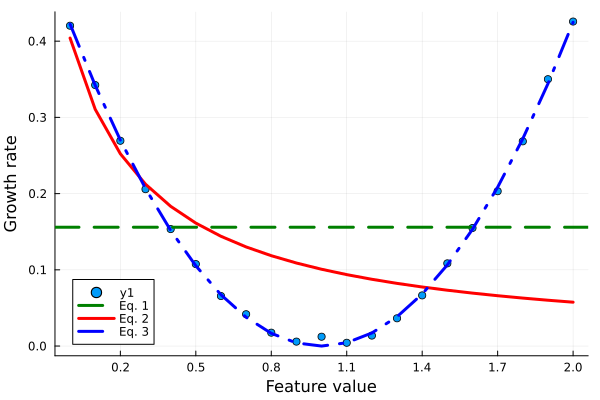

In [25]:
# Plot results of symbolic regression
scatter(results_fit[2, 2:end], results_fit[6, 2:end], xlabel="Feature value", ylabel="Growth rate")
hline!(unique(gr_sy_reg[3][:, 1]), label=["Eq. 1" nothing], line=(3, :green, :dash))
plot!(unique(results_fit[2, 2:end]), unique(gr_sy_reg[3][:, 2]), label=["Eq. 2" nothing], line=(3, :red))
plot!(unique(results_fit[2, 2:end]), unique(gr_sy_reg[3][:, 3]), label=["Eq. 3" nothing], line=(3, :blue, :dashdot))